# MIMO - Three benefits of multiple antenna communications 

In the evolving world of wireless communication, the integration of multiple antennas in base stations and user devices is highly relevant. There are multiple performance benefits of such antenna configurations where the three most well established are: beamforming gains, spatial multiplexing gains, and diversity gains.

With only two members in our team, we concentrate on spatial multiplexing gains and diversity gains. Through mathematical formulas and simulations, our objective is to uncover and showcase the practical advantages of these aspects, contributing valuable insights to this field of wireless communication.

### Background and related work

- Where is this idea born 
- How has it been effective
- The current relevant usecases 

### Beamforming Gains

- Explanation 
- Relevant formulas 
- Some illustration plots 

## Spatial Multiplexing Gains

- Explanation 
- Relevant formulas 
- Some illustration plots 

### Method

For the simulation of the Spatial Multiplexing Gains I decided simulate the received power gain at three three users.

First of all the goal is to be able to focus the transmissions in three directions at the same time and frequency.

So different from the singular beam forming where only a singular receiver can be reached at a time. 

For simplicity and because of the short scope of the project I decided to go with linear array antenna simulation.


Starting by defining a Class called MIMOConfig, that is initialized with a number of antennas and an array of the angels the receivers are situated at. 

Furthermore all the simulations are executed with the frequency 3Ghz, there fore its a global constant. 
The number of antennas used for each beamforming is evenly divided amongst the receivers.

The antenna spacing (d) is half a wavelength, that is derived from the frequency
$$
\lambda  =\dfrac{\textit{c}}{\textit{f}}
$$

$$
\textit{d} = \dfrac{\lambda}{2}
$$



For each of the receiver angles we generate a Array response, and then compute the superposition of said Arrays 

### Formulas 

$$
\textit{n} = \{1, 2, 3, \ldots, M\}
$$

$$
\theta = \sum_{i=0}^{359} i \cdot \frac{\pi}{180}
$$

$$
X = \exp\left(-j \cdot (n - 1) \cdot 2 \pi \cdot \frac{d \cdot \cos(\theta_{\text{rad}})}{\lambda}\right)
$$

$$
w = \exp\left(j \cdot (n - 1) \cdot 2 \pi \cdot \frac{d \cdot \cos(\phi_{\text{rad}})}{\lambda}\right)
$$

$$
\begin{align*}
& n \text{ is the array index} \\
& \theta \text{ is the array of angles from } 0 \text{ to } 2\pi \\
& \phi \text{ is the angle of the receiver position}\\
& d \text{ is the antenna spacing} \\
& \lambda \text{ is the wavelength of the signal}
\end{align*}
$$


$$
\text{ArrayResponse} = w^\intercal \cdot X
$$

Then the superposition function then iterates over each array, and for each array, it adds the weighted contribution to reults array 


$$
weights = \frac{1}{\text{num\_arrays}} \cdot \mathbf{1}
$$


$$
\text{Superposition of array responses} = \sum_{i=1}^{\text{num\_arrays}} \text{weights}[i] \cdot \text{arrays}[i]
$$

or another way to put it where n stands for the number of arrays 

$$
\text{Superposition of array responses} = \frac{1}{n} \cdot (\text{Array}_1 + \text{Array}_2 + \ldots + \text{Array}_n)
$$

Then to get the Array Response of a specific angle is simple since the superposition array can simply by indexed by the angle in degrees, since theta is 360 values, and therefore indexes the array 
$$
\text{array\_response\_at\_angle} = \left| \text{Superposition Array}[\phi_{deg}] \right|
$$

Finally calculate the gain in dBi
$$
G_t (\text{dBi}) = 10 \cdot \log_{10}(\text{ArrayResponseAtAngle})
$$


## Initilazation code
Where the config is generated 

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Constants used
SPEED_OF_LIGHT  = 3e8
FREQUENCY       = 3e9 # 3GHz
THETA           = np.arange(0, 2 * np.pi, np.pi / 180) #Theta values from 0 to 2*pi

class MIMOConfig:
    def __init__(self, num_antennas, receiver_angles_deg):

        # Number of receivers determined from the number of angles 
        self.num_receivers = len(receiver_angles_deg)

        # self.num_antennas = num_antennas // self.num_receivers - this is not correct
        self.num_antennas = num_antennas

        self.receiver_angles_deg = receiver_angles_deg
        self.receiver_angles_rad = [
            angle*(np.pi/180) for angle in receiver_angles_deg
        ]    
        
        # Calculate antenna spacing ( wavelength/2 ) (C/F)/2
        self.wavelength = SPEED_OF_LIGHT / FREQUENCY
        self.antenna_spacing = self.wavelength / 2
        
        self.array_responses = [
            self.getArrayResponse(angle_rad) for angle_rad in self.receiver_angles_rad
        ]

    def getArrayResponse(self, angle_rad):

        # Array indices
        n = np.arange(1,self.num_antennas + 1)
       
        # Reshape n to a column vector
        n = n.reshape(-1, 1)

        # Array response matrix
        X = np.exp(-1j * (n - 1) * 2 * np.pi * self.antenna_spacing * np.cos(THETA) / self.wavelength)
       
        # Weight vector for steering
        w = np.exp(1j * (n - 1) * 2 * np.pi * self.antenna_spacing * np.cos(angle_rad) / self.wavelength)
        w = w.reshape(-1, 1)
        # Array response with steering
        #self.array_responses = np.dot(w.T, X)
        return np.dot(w.T, X)

### Helper functions 

Calculate the superposition of the arrays 
And from that calculate the angularGain in dBi

In [29]:

def angularGainInDBi(superpossition, angle_deg):
        
        # The number of THETA's used = 360 - one per deg (so angle_deg can be the index)
        array_response_at_angle = np.abs(superpossition[0][angle_deg])

        # Calculate the gain of the transmitting antenna based on the array response
        Gt_dB = 10 * np.log10(array_response_at_angle)

        return Gt_dB


# Calculate the superposition of array_responses 
def superpose(arrays):
    num_arrays = len(arrays)
    weights = np.ones(num_arrays) / num_arrays  # Even weights
    result = np.zeros_like(arrays[0])
    for i in range(num_arrays):
        result += weights[i] * arrays[i]
    return result

def polarPlot(array):
    plt.figure(figsize=(10, 6))
    plt.polar(THETA, np.abs(array.flatten()), 'b')
    #plt.title()
    #plt.legend()
    plt.show()

Now we can show a simple setting - and visualize the scenario at hand

First lets look at a simple beamforming 

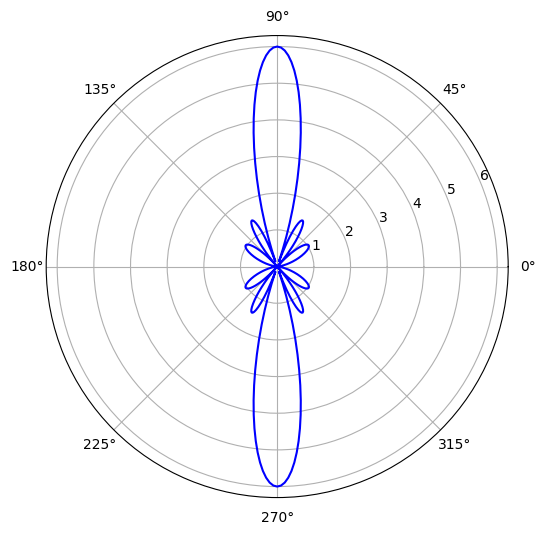

In [30]:

beamformingConfig = MIMOConfig(num_antennas=6, receiver_angles_deg=[90])
sp_beamforming = superpose(beamformingConfig.array_responses)
polarPlot(sp_beamforming)

Then look at a simple Spatial Multiplexing case

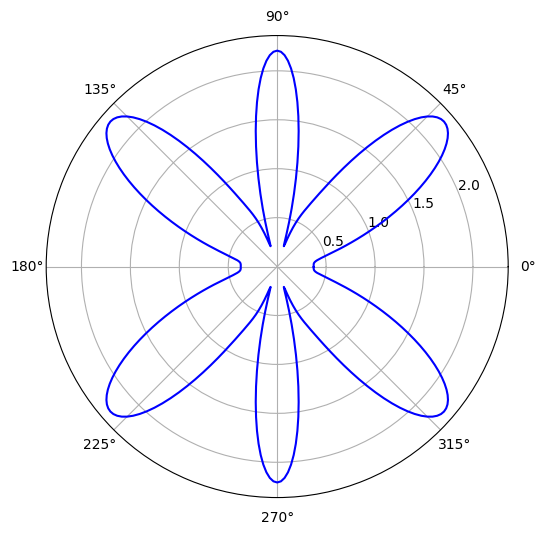

In [31]:
config1 = MIMOConfig(num_antennas=6, receiver_angles_deg=[135,90,45])
sp = superpose(config1.array_responses)
polarPlot(sp)

However there needs to be sufficient space, or in our case ange between the recievers
Or we cant tell the transmissions apart 

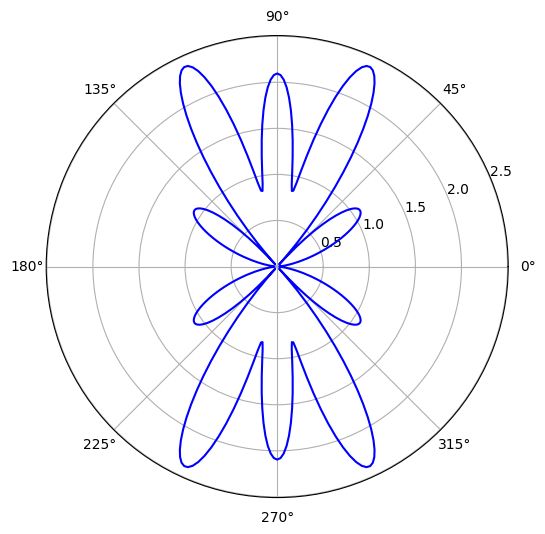

In [32]:
config2 = MIMOConfig(num_antennas=6, receiver_angles_deg=[110,90,70])
sp2 = superpose(config2.array_responses)
polarPlot(sp2)

The optimal separation angle for 3 users would be what ? 
How can it be effected ? 

We add another helper function that can iterates over multiple cases
- Testing different angles of separation and numbers of antennas used 

In [33]:
################################################################################################
#                                       DATA COLLECTION                                        #
################################################################################################

def iterateOverAnglesAndAntennas(separation_angles, antenna_counts, offset_angle=0):
    
    data = {"Antennas": [], "Separation_Angle": [], "Receiver1": [], "Receiver2": [], "Receiver3": []}
    for num_antennas in antenna_counts:
        for separation in separation_angles:
            centered_reciver_angle = 90-offset_angle

            config = MIMOConfig(num_antennas=num_antennas, receiver_angles_deg=[centered_reciver_angle+separation , centered_reciver_angle, centered_reciver_angle-separation])
            sp = superpose(config.array_responses)

            data["Antennas"].append(num_antennas)
            data["Separation_Angle"].append(separation)
            data["Receiver1"].append(angularGainInDBi(sp, centered_reciver_angle + separation ))
            data["Receiver2"].append(angularGainInDBi(sp, centered_reciver_angle ))
            data["Receiver3"].append(angularGainInDBi(sp, centered_reciver_angle - separation))
            
        
    return data

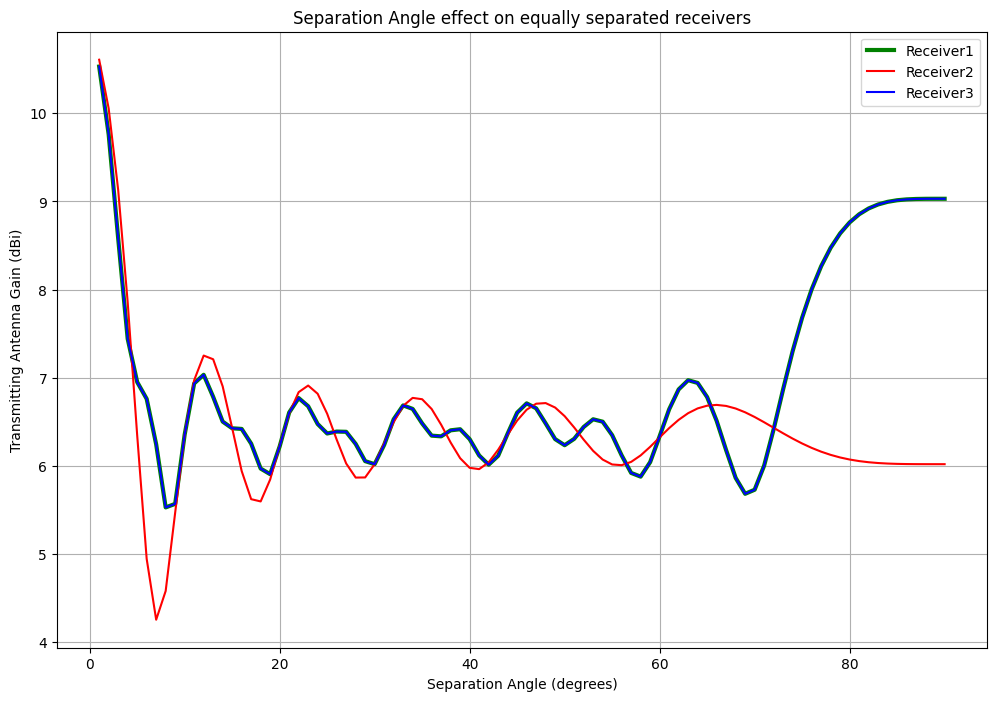

In [34]:
# First check for 3 receivers - the degree of separation effect [90-1 degree separation]
separation_angles = np.arange(90, 0, -1)  # Iterate from 90 to 1 degree of separation
antenna_counts = [12]  # Antenna configurations to test

separation_data = iterateOverAnglesAndAntennas(separation_angles, antenna_counts)
plt.figure(figsize=(12, 8))

plt.plot(separation_data["Separation_Angle"], separation_data["Receiver1"], label=f"Receiver1", color="green", linewidth=3)
plt.plot(separation_data["Separation_Angle"], separation_data["Receiver2"], label=f"Receiver2", color="red")
plt.plot(separation_data["Separation_Angle"], separation_data["Receiver3"], label=f"Receiver3", color="blue")

plt.title('Separation Angle effect on equally separated receivers')
plt.xlabel('Separation Angle (degrees)')
plt.ylabel('Transmitting Antenna Gain (dBi)')
plt.legend()
plt.grid(True)
plt.show()


The Blue and green line represent the receivers not at the 90 degree angle - and there for mirror each other 

However the sweet spot is in between 30 - 60 degree separation 
The rased values on the other sides are simply the effect of the beams colliding together and forming a singular beam 

Like shown above

This can be enhanced by increasing the number of antennas used - where the beam can be focused to a much narrower point

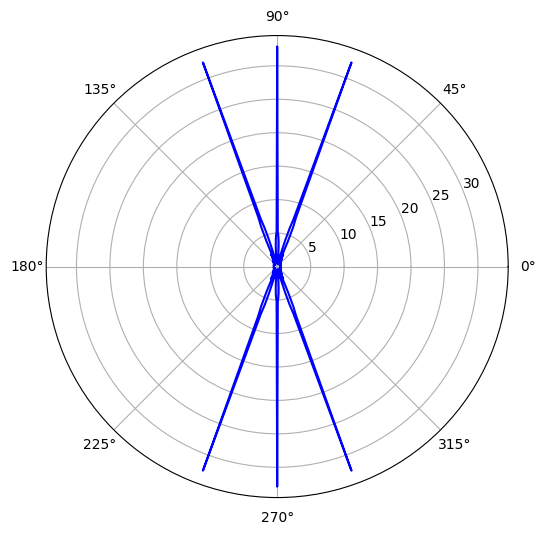

In [35]:

config3 = MIMOConfig(num_antennas=96, receiver_angles_deg=[110,90,70])
sp3 = superpose(config3.array_responses)
polarPlot(sp3)

Taking another look at the graph from before with different number of antennas 

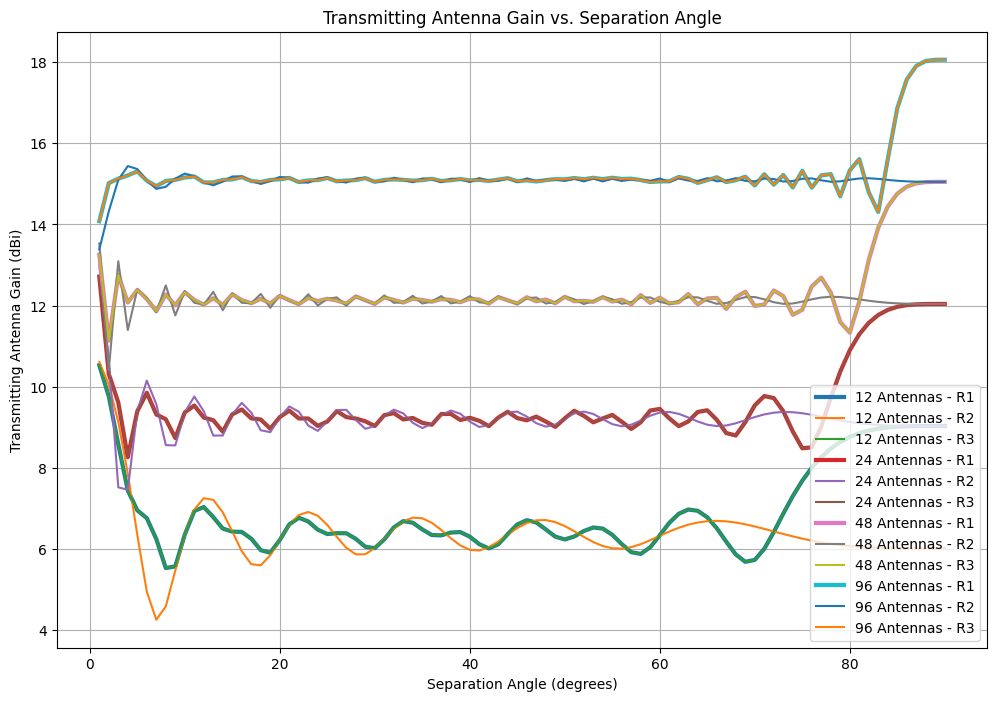

In [36]:

# Repeating the same scenario but increacing the number of antennas plotting them all 
antenna_counts = [12, 24, 48, 96]  # Antenna configurations to test
separation_variable_antenna_data = iterateOverAnglesAndAntennas(separation_angles, antenna_counts)
plt.figure(figsize=(12, 8))

for num_antennas in antenna_counts:
    #Filter data for the current number of antennas
    filtered_data = {key: [val[i] for i, antennas in enumerate(separation_variable_antenna_data["Antennas"]) if antennas == num_antennas] for key, val in separation_variable_antenna_data.items()}

    plt.plot(filtered_data["Separation_Angle"], filtered_data["Receiver1"], label=f"{num_antennas} Antennas - R1", linewidth=3)
    plt.plot(filtered_data["Separation_Angle"], filtered_data["Receiver2"], label=f"{num_antennas} Antennas - R2")
    plt.plot(filtered_data["Separation_Angle"], filtered_data["Receiver3"], label=f"{num_antennas} Antennas - R3")

plt.title('Transmitting Antenna Gain vs. Separation Angle')
plt.xlabel('Separation Angle (degrees)')
plt.ylabel('Transmitting Antenna Gain (dBi)')
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()

We can se that the higher the number of antennas - the higher the gain, and further more the angle of separation can be much smaller (and higher)

Looking into the offset ? 